In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

### Helper functions for integration

In [61]:
# integration tools

def adaptiv_integral(f, x1, x2, y1, y2, e=1e-5): 
    # global counter
    # adaptive Funktion for calculation an 2D integral
    # --> x2 > x1 and y2 > y1
    area = (x2 - x1)*(y2 - y1)
    trapez = trapez_rule(f, x1, x2, y1, y2)
    simpson = simpson_rule(f, x1, x2, y1, y2)
    err = np.abs(trapez - simpson)

    if err > e:                 # Abhängig von der größer des Feldes? 
        mx = (x2 + x1) / 2
        my = (y2 + y1) / 2

        integral = adaptiv_integral(f, x1, mx, y1, my) + adaptiv_integral(f, mx, x2, y1, my) + \
            adaptiv_integral(f, x1, mx, my, y2) + adaptiv_integral(f, mx, x2, my, y2)
    else:
        integral = simpson

    return integral


def trapez_rule(f, x1, x2, y1, y2):
    area = (x2 - x1)*(y2 - y1)

    return area*(f(x1, y1) + f(x1, y2) + f(x2, y1) + f(x2, y2))/4


def simpson_rule(f, x1, x2, y1, y2):
    x = np.linspace(x1, x2, 3)
    y = np.linspace(y1, y2, 3)
    hx = x[1] - x[0]
    hy = y[1] - y[0]
    singles = f(x[0], y[0]) + f(x[2], y[0]) + f(x[0], y[2]) + f(x[2], y[2])
    fours = f(x[1], y[0]) + f(x[2], y[1]) + f(x[1], y[2]) + f(x[0], y[1])

    return hx*hy*(singles + 4*fours + 16*f(x[1], y[1]))/9

def polar_to_kart(r, phi):
    x, y = r*np.cos(phi), r*np.sin(phi)
    return x, y



# Initialize board

In [66]:
class Board:

    numbers = [6, 13, 4, 18, 1, 20, 5, 12, 9, 14, 11, 8, 16, 7, 19, 3, 17, 2, 15, 10]

    # lenght of radien
    radius_of_board = 170
    bullseye = 6.35
    singlebull = 15.9
    triple_inner = 99
    triple_outer = 107
    dopple_inner = 162
    dopple_outer = radius_of_board

    radien = [0, bullseye, singlebull, triple_inner, triple_outer, dopple_inner, dopple_outer]
    radien_factor = [2, 1, 1, 3, 1, 2, 0]   # factor for each ring (3 --> triple field)

    def __init__(self, target=[0, 0], sigma=10):
        self.target = target                    # expected value 
        self.sigma = sigma              # std
        self.r = np.linalg.norm(target)     # distance to the center 

    def get_factor(self):
        factor = 0
        for k in range(len(self.radien) - 1):
            if self.r > self.radien[k] and self.r < self.radien[k+1]:
                factor = self.radien_factor[k]
                break
        return factor

    def get_score(self):
        return self.get_number()*self.get_factor()
    
    def get_number(self):
        x, y = self.target
        if self.r <= self.radien[2]:
            num = 25
        elif self.r > self.radien[-1]:
            num = 0
        else:
            try:
                phi = np.arctan(y/x)
            except ZeroDivisionError:
                phi = np.sign(y)*np.pi/2
            ang = 18/360*2*np.pi
            if x < 0:
                phi += np.pi 
            else:
                if y < 0:
                    phi += 2*np.pi
            for i in range(20):
                ang1 = ang*(i-1/2)
                ang2 = ang*(i+1/2)
                num = 6  # to define the first value 
                if phi > ang1 and phi < ang2:
                    num = self.numbers[i]
                    break
        return num

    def get_ev(self, event=None):
        e = 0
        # integrate bull and single bull
        for i in range(2):
                e += adaptiv_integral(self.prob_density_polar, self.radien[i], self.radien[i+1], 0, 2*np.pi)*25*self.radien_factor[i]

        # integrate the rest
        for i in range(2, len(self.radien)-1):
            r1 = self.radien[i]
            r2 = self.radien[i+1]
            for k in range(20):
                phi1 = 18/360*2*np.pi * (k - 1/2) 
                phi2 = 18/360*2*np.pi * (k + 1/2) 
                e += adaptiv_integral(self.prob_density_polar, r1, r2, phi1, phi2)*self.numbers[k]*self.radien_factor[i]

        if e < self.get_score()/self.sigma and np.linalg.norm(self.target) < self.radius_of_board:
            warnings.warn("Calculation failed! \n Sigma to small for Adaptive Integration")
        if event == None:
            return e
        else:
            print(f'Erwartungswert = {e}') 

    # vielleicht noch überarbeiten 
    def prob_density_polar(self, r, phi):
        factor = r/(2*np.pi*self.sigma**2)
        ev = (np.cos(phi)*r - self.target[0])**2 + (np.sin(phi)*r - self.target[1])**2
        return factor*np.exp(-ev/(2*self.sigma**2))

# Analysis
We asume the targets to be the bullseye and the center of every triple field 

In [145]:
cols = ["sigma", "Bull"]
for i, val in enumerate(Board.numbers):
    cols.append(val)

df = pd.DataFrame(columns=cols)
df

,sigma,Bull,6,13,4,18,1,20,5,12,...,11,8,16,7,19,3,17,2,15,10


In [146]:
# Radius center of board - center triple field
b = Board()
r = (b.triple_inner + b.triple_outer)/2  
ang = 2*np.pi / 20

In [187]:
import numba

In [196]:
def around_the_board(sigma):
    result = {"sigma": sigma}
    # Bullseye first 
    b.sigma = sigma 
    b.target = [0, 0]
    result["Bull"] = b.get_ev()

    for i, num in enumerate(b.numbers):
        x, y = polar_to_kart(r, ang*i)
        b.target = [x, y]
        result[num] = b.get_ev()
    return result

In [195]:
df = pd.DataFrame(columns=cols)
for i in tqdm(range(1, 20)):
    res = around_the_board(i)
    res = pd.DataFrame.from_dict([res])
    df = pd.concat([df, res], ignore_index=True)
df

  0%|          | 0/19 [00:00<?, ?it/s]


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'b':[0m [1m[1mCannot determine Numba type of <class '__main__.Board'>[0m
[1m
File "..\..\..\..\AppData\Local\Temp\ipykernel_17276\2359219544.py", line 5:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

<AxesSubplot:>

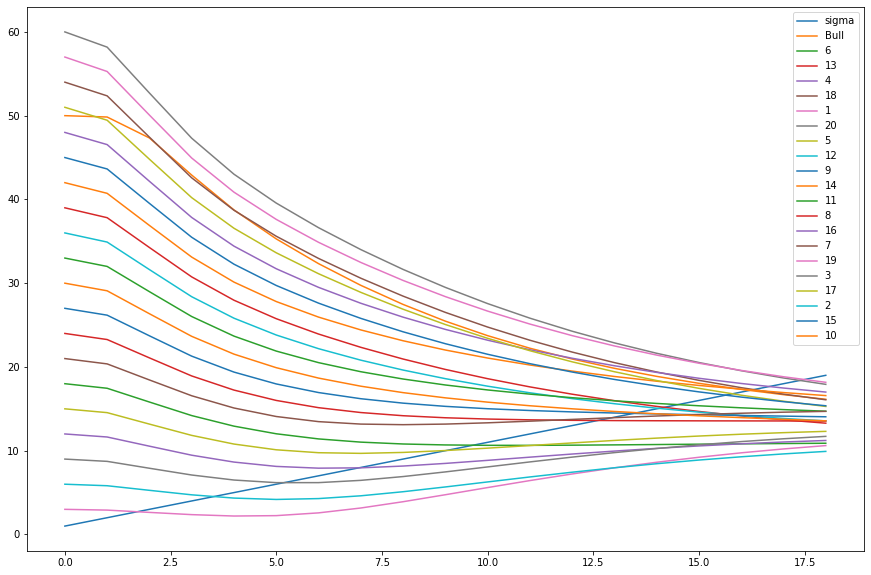

In [186]:
df.plot(figsize=[15, 10])

In [139]:
df.set_index("sigma")

,Bull,6,13,4,18,1,20,5,12,9,...,11,8,16,7,19,3,17,2,15,10
sigma,,,,,,,,,,,,,,,,,,,,,
2.0,49.838225,17.454437,37.817947,11.636291,52.363311,2.909073,58.181457,14.545364,34.908874,26.181656,...,31.999801,23.272583,46.545166,20.36351,55.272384,8.727219,49.454239,5.818146,43.636093,29.090729


TypeError: 'RangeIndex' object is not callable